In [ ]:
import sys
sys.path.append("../scripts")
from gen_torch_datasets import gen_dataloaders, to_cuda, plot_metrics

In [6]:
train_loader, val_loader, input_shape, num_classes = gen_dataloaders(
    "/home/henrik/Documents/EDTH/CPH2025/drone_acoustics_train_val_data",
    4, 
    144
)

Train samples: 540
Train labels 2160
Val samples: 180
Val labels 720


In [ ]:
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
class SpectrogramCNNExample(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SpectrogramCNNExample(num_classes=num_classes)
model, device = to_cuda(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
metrics = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

# Training loop
for epoch in twdm(range(100)):
    model.train()
    correct = 0
    total = 0
    acc = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
        acc = correct / total
        optimizer.step()
    metrics["train_loss"].append(loss.item())
    metrics["train_acc"].append(acc)

    # Validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    acc = correct / total
    metrics["val_acc"].append(acc)


Number of GPUs: 1
Device 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU


Epoch 200: 100%|██████████| 15/15 [00:01<00:00, 11.02it/s]


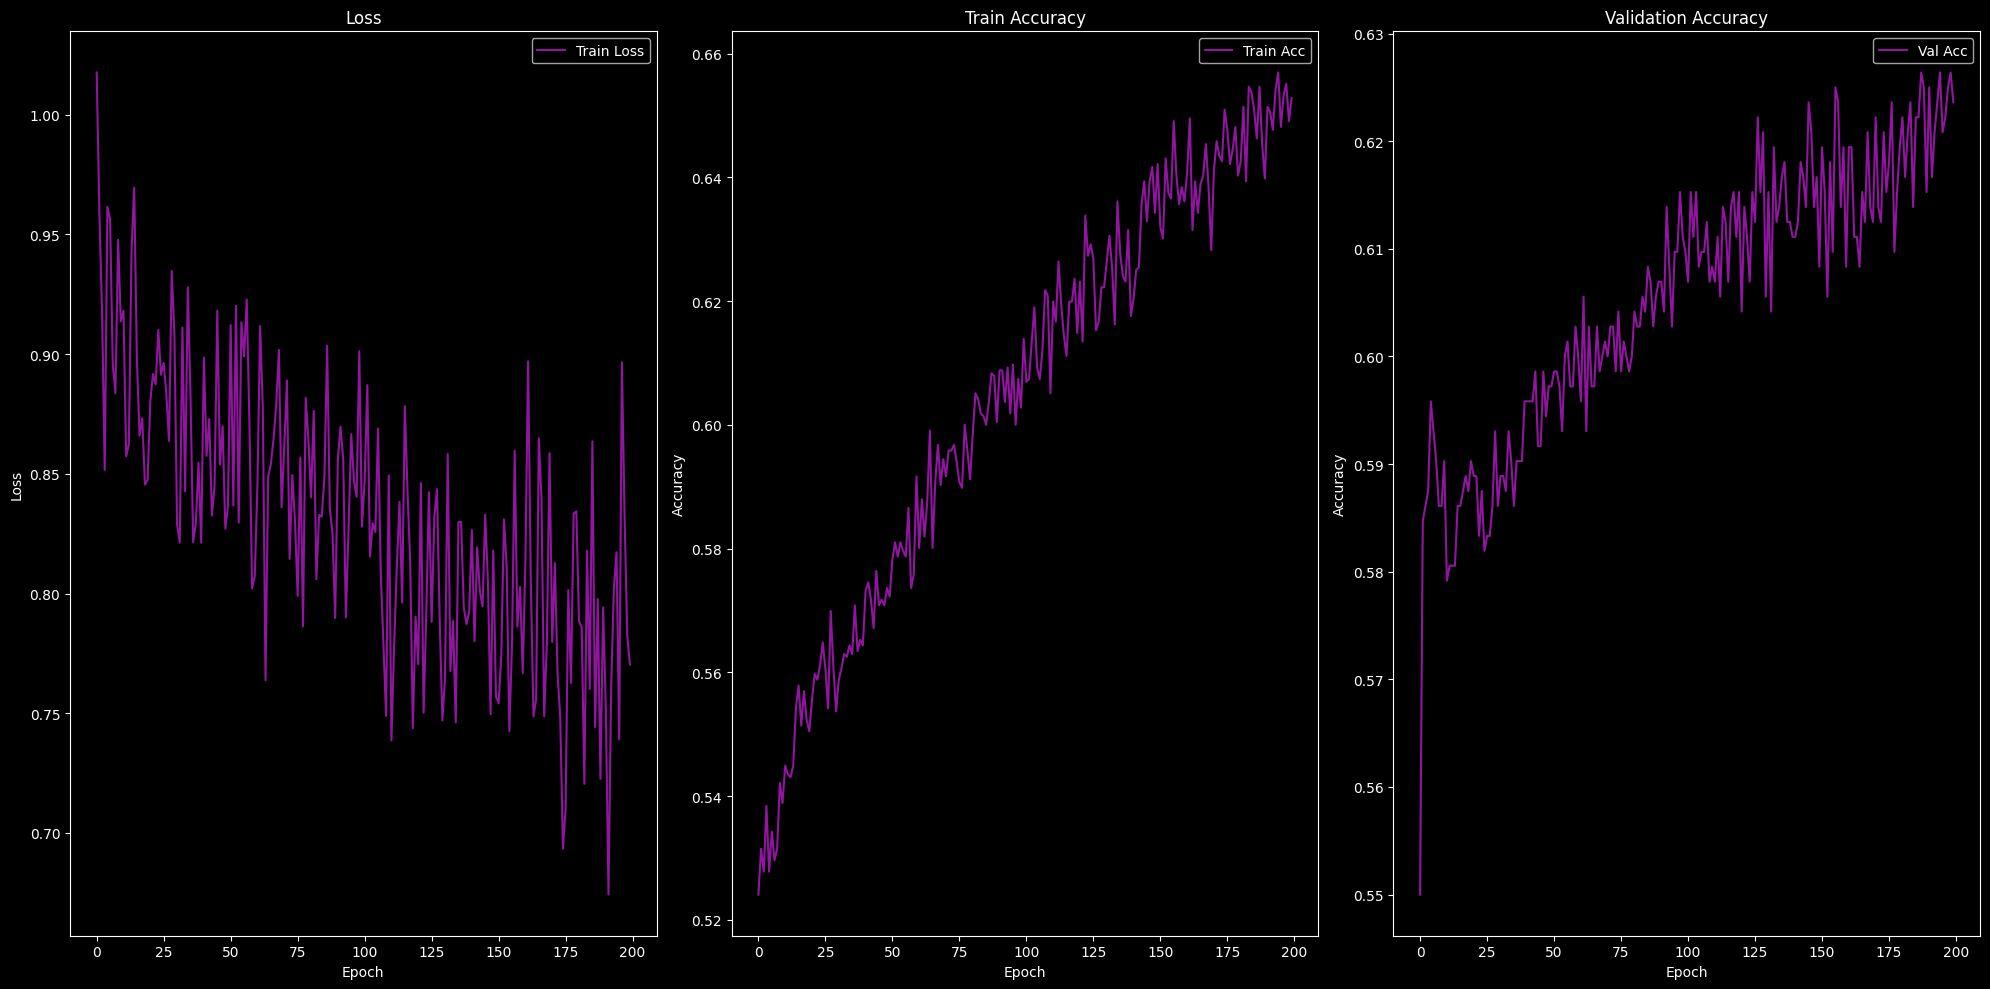

In [ ]:
plot_metrics(metrics)